
#### <center>Deep Neural Networks, Representation Learning, and Text Analytics</center>

### <center>Part 1 </center>
#### <center>Deep Feedforward Neural Network</center></center>

In [1]:
import os
if not os.path.exists("./models/dnn0"):
    os.makedirs("models/dnn0")

In [2]:
# Load the data into numpy array format of two variables

import numpy as np
import scipy.io as sio
data = sio.matlab.loadmat("datasets/notMNIST_small.mat")
x, y =data['images'],data['labels']
x = np.rollaxis(x, axis=2)

In [3]:
#Print out the total number of data points, and the unique labels in this dataset.

print("There are {} data points and {} unique labels".format(x.shape[0],len(list(set(y)))))

There are 18724 data points and 10 unique labels


In [4]:
# this function is a utility to display images from the dataset
# Display 100 images in the form of 10x10 matrix, each row showing 10 random images of a label

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def display_images(images, shape):
    fig = plt.figure(figsize=shape)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(np.prod(shape)):
        p = fig.add_subplot(shape[0], shape[1], i+1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)  

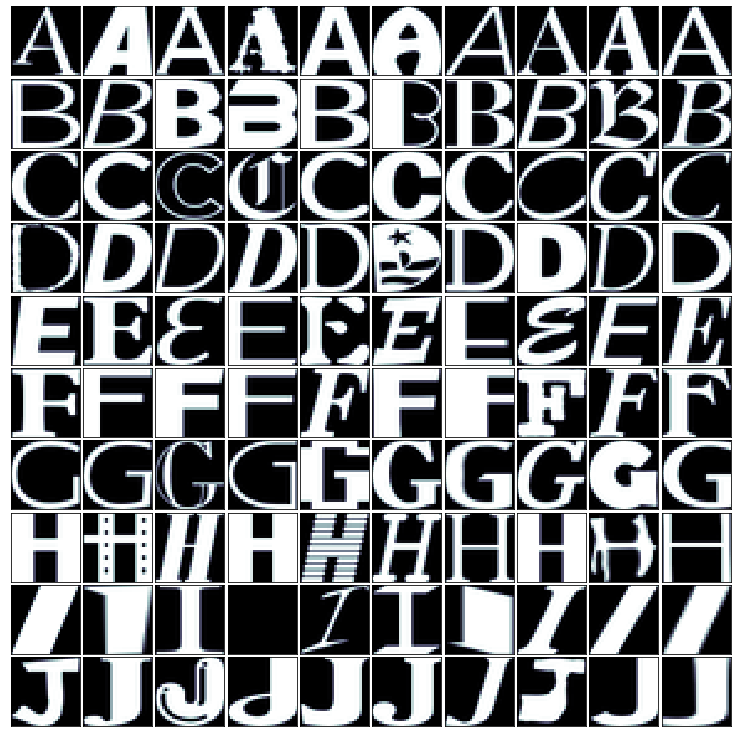

In [5]:
unique_labels = list(set(y))
images = []
for l in unique_labels:    
    idx = np.where(y == l)[0]
    idx = idx[np.random.permutation(len(idx))[:10]]    
    for i in idx:
        images += [x[i]]

display_images(images, shape=(10, 10))

In [6]:
# Use the deep feedforward neural network as the classifier to perform images classification task in a single split training and testing

x = x.reshape([x.shape[0], x.shape[1]*x.shape[2]])

In [7]:
#Rescale the input data into the range of [0, 1]

x = x/255

In [8]:
# Split the data into two subsets: 70% for training and 30% for testing. Note that you must use Stratified-Shuffle-Split to make sure training and testing are balanced and randomly shuffled before learning the model.

from sklearn.model_selection import StratifiedShuffleSplit
str_shu_spl = StratifiedShuffleSplit(train_size=0.7, test_size=0.3, random_state=101)
for train_index, test_index in str_shu_spl.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [9]:
# Construct a deep feedforward neural network 
import tensorflow as tf

tf.reset_default_graph()

num_inputs = x.shape[1]
num_hidden1 = 500
num_hidden2 = 500
num_outputs = len(list(set(y)))

inputs = tf.placeholder(tf.float32, shape=(None, num_inputs), name="X")
labels = tf.placeholder(tf.int64, shape=(None), name="y")

/home/kiran/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kiran/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kiran/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kiran/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: Futu

In [10]:
def neuron_layer(x, n_neurons, name, activation=None):
    with tf.name_scope(name):
        init = tf.truncated_normal((int(x.get_shape()[1]), n_neurons), stddev=0.05)
        weights = tf.Variable(init, name="weights")
        bias = tf.Variable(tf.zeros([n_neurons]), name="biases")
        z = tf.matmul(x, weights) + bias
    if activation == "sigmoid":
        return tf.nn.sigmoid(z)
    elif activation == "relu":
        return tf.nn.relu(z)
    else:
        return z

In [11]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(inputs, num_hidden1, "hidden1", activation="relu")
    hidden2 = neuron_layer(hidden1, num_hidden2, "hidden2", activation="relu")
    logits = neuron_layer(hidden2, num_outputs, "outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("evaluation"):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
learning_rate=0.0011    

with tf.name_scope("train"):
    optimiz = tf.train.GradientDescentOptimizer(learning_rate)
    training_operation = optimiz.minimize(loss)
    grads = optimiz.compute_gradients(loss)
    
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name + "/values", var)
    for grad, var in grads:
        if grad is not None:
            tf.summary.histogram(var.op.name + "/gradients", grad)

accuracy_summary = tf.summary.scalar("accuracy",accuracy)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# merge all summary
tf.summary.histogram('hidden1/activations', hidden1)
tf.summary.histogram('hidden2/activations', hidden2)
merged = tf.summary.merge_all()

init = tf.global_variables_initializer()
saver = tf.train.Saver()

train_writer = tf.summary.FileWriter("models/dnn0/train", tf.get_default_graph())
test_writer = tf.summary.FileWriter("models/dnn0/test", tf.get_default_graph())

num_epochs = 50
batch_size = 128

In [13]:
# code to train the DNN

with tf.Session() as sess:
    init.run()
    print("Epoch\tTrain accuracy\tTest accuracy")
    for epoch in range(num_epochs):
        for idx_start in range(0, X_train.shape[0], batch_size):
            idx_end = idx_start+num_epochs
            x_batch, y_batch = X_train[idx_start:idx_end], y_train[idx_start:idx_end]
            sess.run(training_operation, feed_dict={inputs: x_batch, labels: y_batch})
            
        summary_train, acc_train = sess.run([merged, accuracy],feed_dict={inputs: x_batch, labels: y_batch})
        summary_test, acc_test = sess.run([accuracy_summary, accuracy],feed_dict={inputs: X_test, labels: y_test})
        
        train_writer.add_summary(summary_train, epoch)
        test_writer.add_summary(summary_test, epoch)
        
        print("{}\t{}\t{}".format(epoch, acc_train, acc_test))

    save_path = saver.save(sess, "models/dnn0.ckpt")

Epoch	Train accuracy	Test accuracy
0	0.2800000011920929	0.23709505796432495
1	0.5199999809265137	0.42061230540275574
2	0.699999988079071	0.5779637098312378
3	0.8600000143051147	0.6803132891654968
4	0.8600000143051147	0.7363830804824829
5	0.8600000143051147	0.7671769261360168
6	0.8600000143051147	0.787112832069397
7	0.8600000143051147	0.801886796951294
8	0.8799999952316284	0.8134567737579346
9	0.8799999952316284	0.8200427293777466
10	0.8999999761581421	0.8244926929473877
11	0.8999999761581421	0.8273406624794006
12	0.8999999761581421	0.8314346671104431
13	0.8999999761581421	0.833570659160614
14	0.8999999761581421	0.8373086452484131
15	0.8999999761581421	0.8399786353111267
16	0.8999999761581421	0.842470645904541
17	0.8999999761581421	0.8440726399421692
18	0.8999999761581421	0.8451406359672546
19	0.8999999761581421	0.8463866114616394
20	0.8999999761581421	0.8481665849685669
21	0.8999999761581421	0.8497685790061951
22	0.8999999761581421	0.8506585955619812
23	0.8999999761581421	0.85208261013

In [14]:
# Part 2: Word2Vec, Text Analytics and Application

In [15]:
# download the dataset.

from sklearn.datasets import fetch_20newsgroups
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers'))

In [16]:
# Print out the total number of documents, and the unique labels in this dataset.
print("There are {} documents points and {} unique labels".format(len(newsgroups_all['data']),len(newsgroups_all.target_names)))

There are 18846 documents points and 20 unique labels


In [17]:
# Convert the documents into a list of tokens using the function gensim.utils.tokenize
import gensim
word_embds = [list(gensim.utils.tokenize(document)) for document in newsgroups_all['data']]

In [18]:
#Train gensim's word2vec model.
from gensim.models import Word2Vec
word_embds_model = Word2Vec(word_embds, size=100, window=5, min_count=5, workers=4)

In [19]:
# Save the trained model to a file named "20_newsgroups.gensim"
word_embds_model.save("20_newsgroups.gensim")

In [20]:
# Print out the vocabulary size
print("Size of the vocabulary : ",word_embds_model.wv.vectors.shape[0])

Size of the vocabulary :  42461


In [21]:
# Using the embedding results, calculate and print out the ten most similar words to word 'law' and their corresponding similarity scores.

print("Most simal words to the word law\n_________________________________ ")
top_10 = word_embds_model.most_similar(positive=['law'],topn=10)
print("Word--Score\n")
for i in top_10:
    print(str(i[0])+"--"+str(i[1]))

Most simal words to the word law
_________________________________ 
Word--Score

enforcement--0.7479267716407776
government--0.7324967384338379
court--0.7167355418205261
laws--0.7137134671211243
legal--0.7060520648956299
legitimate--0.6978418827056885
constitution--0.6920261383056641
private--0.691967248916626
property--0.6891624927520752
rights--0.6811025142669678


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


In [22]:
#  Extract document vectors using sum
def extract_doc2vec(doc, w2v):
    vecs = [w2v[word] for word in doc if word in w2v]
    if len(vecs) > 0:
        vecs = np.asarray(vecs).sum(axis=0)
    return vecs

In [23]:
x,y= [],[]

for i in range(len(newsgroups_all['data'])):
    edv = extract_doc2vec(newsgroups_all['data'][i],word_embds_model.wv)
    if len(edv)>0:
        x.append(edv)
        y.append(newsgroups_all['target'][i])

In [24]:
# Print out the number of documents retained after removing empty documents.

print("Number of documents retained after removing empty documents",len(x))

Number of documents retained after removing empty documents 18811


In [25]:
x = np.asarray(x)
y = np.asarray(y)

In [26]:
# Split the data into two subsets: 70% for training and 30% for testing. Note that you must use Stratified-Shuffle-Split to make sure training and testing are balanced and randomly shuffled before learning the model.

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(train_size=0.7, test_size=0.3, random_state=0)

for train_index, test_index in sss.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [29]:
# Use Logistic Regression as the classifier, train and test the model using the training and test datasets from the previous step. Report the training accuracy and testing accuracy.

from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)

/home/kiran/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [30]:
from sklearn.metrics import accuracy_score
y_pred = logReg.predict(X_test)
print("Sum based train Score: ",accuracy_score(y_train,logReg.predict(X_train)))
print("Sum based test Score: ",accuracy_score(y_test,y_pred))

Sum based train Score:  0.20141262246525404
Sum based test Score:  0.18763288447909285


In [31]:
# Now modify the extract_doc2vec function above to extract document vectors using average, instead of sum, and repeat the experiment: split the data, train and test using Logistic Regression.¶

def extract_doc2vec(doc, w2v):
    vecs = [w2v[word] for word in doc if word in w2v]
    if len(vecs) > 0:
        vecs = np.asarray(vecs).mean(axis=0)
    return vecs
y = []
x = []
for i in range(len(newsgroups_all['data'])):
    edv = extract_doc2vec(newsgroups_all['data'][i],word_embds_model.wv)
    if len(edv)>0:
        x.append(edv)
        y.append(newsgroups_all['target'][i])

In [32]:
x = np.stack(x)
y = np.stack(y)

In [33]:
for train_index, test_index in sss.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [34]:
logReg = LogisticRegression(random_state=101, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)

/home/kiran/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [35]:
y_pred = logReg.predict(X_test)
print("Average based train Score: ",accuracy_score(y_train,logReg.predict(X_train)))
print("Average based test Score: ",accuracy_score(y_test,y_pred))

Average based train Score:  0.2698412698412698
Average based test Score:  0.2563784549964564


### Sum and Average performance evaluation.

On observing the values of 'sum of vectors' and 'average of vectors' it is evident that the acuuracy haven't crossed 27%.

#### Scores of Average of Vectors:
Training Score: 26.1%
Testing Score: 25.4%

#### Scores of Sum of Vectors:
Training Score: 20%
Testing Score: 19%


On training classification models involving numerical data, the accuracy is mostly high as the obtained data will be much reliable. While if the data is text(images of text), noise factor and lack of proper set of limits for the data effects the training and prediction a lot. 

This issue can be minimised to a larger by having some set of rules like detecting and eliminating punctuations, stop characters/words. Techniques like Natural Language processing can also be used for improving the accuracy score to a large extent.
